In [1]:
import mysklearn.mypytable
import importlib
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyNaiveBayesClassifier, MyRandomForestClassifier, MyDecisionTreeClassifier, MyDummyClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import matplotlib.pyplot as plt
from collections import Counter

## Breast Cancer Classification   
#### Cody Kesselring and Owen Rooff   
#### CPSC 322 Fall 2025

## Introduction

This project analyzes the Wisconsin Breast Cancer dataset to classify tumors as either malignant (M) or benign (B). The dataset contains 1,000 instances with 30 numerical features derived from digitized images of fine needle aspirate (FNA) of breast masses. These features describe characteristics of cell nuclei present in the images, including radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, and fractal dimension. Each feature is computed as mean, standard error, and worst (largest) values.

The classification task implemented in this project aims to predict whether a tumor is malignant or benign based on these 30 discretized features. Four different classifiers were evaluated using 10-fold cross-validation: Naive Bayes, Random Forest, Decision Tree, and a Dummy Classifier (baseline). The features were discretized into quartile-based bins (25%, 50%, 75%, 100%) to enable effective classification with these algorithms.

Our findings show that both the Random Forest and Decision Tree classifiers achieved the best performance with an overall accuracy of 95.5% and F1 scores of 0.9547 and 0.9550 respectively. The Naive Bayes classifier also performed well with 93.6% accuracy, while the Dummy Classifier baseline achieved only 46.4% accuracy, confirming that the feature-based approaches significantly outperform random guessing. Random Forest demonstrated the highest precision (96.15%) for detecting malignant tumors, making it the most reliable classifier for this medical application where false negatives can have serious consequences.

### Load Augmented Dataset and Preprocess
Before training the classifiers, we performed the following preprocessing steps:

- **SMOTE Data Augmentation**: Applied the SMOTE (Synthetic Minority Over-sampling Technique) algorithm to balance the dataset and increase sample size from approximately 600 instances to 1,000 instances, ensuring equal representation of malignant and benign cases
- **Feature Discretization**: Transformed all 30 continuous features into categorical bins using quartile-based discretization (25%, 50%, 75%, 100%), creating four discrete categories per feature: "low", "med_low", "med_high", and "high"
- **Feature Representation**: Each instance was represented as a vector of 30 categorical feature values, enabling effective classification with discrete-based algorithms

In [2]:
cancer_table = MyPyTable()
cancer_table.load_from_file('input_data/cancer_augmented.csv')

X = []
y = []

all_features = []
for row in cancer_table.data:
    if row[1] in ['M', 'B']:
        feature_values = [float(row[i]) for i in range(2, 32)]  # 30 features
        all_features.append(feature_values)

# quartiles for each feature
import numpy as np
quartiles = []
for feature_idx in range(30):
    feature_column = [row[feature_idx] for row in all_features]
    q1 = np.percentile(feature_column, 25)
    q2 = np.percentile(feature_column, 50)
    q3 = np.percentile(feature_column, 75)
    quartiles.append((q1, q2, q3))

# discretize features based on quartiles
for row in cancer_table.data:
    if row[1] in ['M', 'B']:
        features = []
        for feature_idx in range(30):
            value = float(row[feature_idx + 2])  
            q1, q2, q3 = quartiles[feature_idx]

            # 4 bins based on quartiles
            if value <= q1:
                features.append(f"f{feature_idx}_low")
            elif value <= q2:
                features.append(f"f{feature_idx}_med_low")
            elif value <= q3:
                features.append(f"f{feature_idx}_med_high")
            else:
                features.append(f"f{feature_idx}_high")

        X.append(features)
        y.append(row[1])  # M or B

print(f"Loaded {len(X)} instances from cancer dataset")
print(f"Sample X: {X[0]}, y: {y[0]}")
print(f"Sample X: {X[1]}, y: {y[1]}")

Loaded 1000 instances from cancer dataset
Sample X: ['f0_high', 'f1_low', 'f2_high', 'f3_high', 'f4_high', 'f5_high', 'f6_high', 'f7_high', 'f8_high', 'f9_high', 'f10_high', 'f11_med_low', 'f12_high', 'f13_high', 'f14_med_high', 'f15_high', 'f16_high', 'f17_high', 'f18_high', 'f19_high', 'f20_high', 'f21_low', 'f22_high', 'f23_high', 'f24_high', 'f25_high', 'f26_high', 'f27_high', 'f28_high', 'f29_high'], y: M
Sample X: ['f0_high', 'f1_med_low', 'f2_high', 'f3_high', 'f4_low', 'f5_med_low', 'f6_med_high', 'f7_med_high', 'f8_med_high', 'f9_low', 'f10_med_high', 'f11_low', 'f12_med_high', 'f13_high', 'f14_low', 'f15_low', 'f16_med_low', 'f17_med_high', 'f18_low', 'f19_med_high', 'f20_high', 'f21_med_low', 'f22_high', 'f23_high', 'f24_med_low', 'f25_med_low', 'f26_med_low', 'f27_high', 'f28_med_low', 'f29_med_high'], y: M


### Visualizing Class Distriubtion

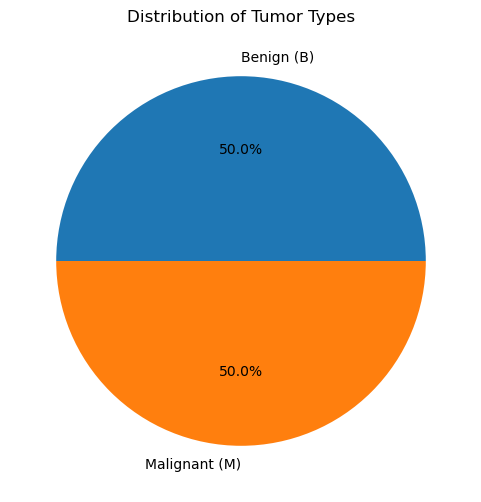

In [3]:
class_counts = Counter(y)
labels = ['Benign (B)', 'Malignant (M)']
sizes = [class_counts['B'], class_counts['M']]

# Pie chart distribution
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of Tumor Types")
plt.show()

### Evaluation Methodology

We employed **10-fold stratified cross-validation** to evaluate classifier performance

In [4]:
folds = myevaluation.kfold_split(X, n_splits=10, random_state=0, shuffle=True)

### Naive Bayes Classifier
The Naive Bayes classifier was implemented using the  independence assumption, calculating prior probabilities for each class and  probabilities for each feature value given the class. During prediction, it computes the posterior probability for each class and selects the class with maximum probability. 


In [5]:
nb_all_y_true = []
nb_all_y_pred = []

print("Running Naive Bayes with 10-fold cross-validation...")
print("="*60)

for fold_idx, (train_indices, test_indices) in enumerate(folds):
    X_train = [X[i] for i in train_indices]
    y_train = [y[i] for i in train_indices]
    X_test = [X[i] for i in test_indices]
    y_test = [y[i] for i in test_indices]

    nb_clf = MyNaiveBayesClassifier()
    nb_clf.fit(X_train, y_train)

    y_pred = nb_clf.predict(X_test)

    nb_all_y_true.extend(y_test)
    nb_all_y_pred.extend(y_pred)

    fold_accuracy = myevaluation.accuracy_score(y_test, y_pred)
    print(f"Fold {fold_idx + 1}: Accuracy = {fold_accuracy:.4f}")

print("="*60)

nb_accuracy = myevaluation.accuracy_score(nb_all_y_true, nb_all_y_pred)
nb_error_rate = 1 - nb_accuracy


print(f"\nOverall Accuracy: {nb_accuracy:.4f}")
print(f"Overall Error Rate: {nb_error_rate:.4f}")

labels = ["B", "M"]

nb_precision = myevaluation.binary_precision_score(nb_all_y_true, nb_all_y_pred,
                                                     labels=labels, pos_label="M")
nb_recall = myevaluation.binary_recall_score(nb_all_y_true, nb_all_y_pred,
                                               labels=labels, pos_label="M")
nb_f1 = myevaluation.binary_f1_score(nb_all_y_true, nb_all_y_pred,
                                      labels=labels, pos_label="M")

print(f"\nPrecision (Malignant): {nb_precision:.4f}")
print(f"Recall (Malignant): {nb_recall:.4f}")
print(f"F1 Score (Malignant): {nb_f1:.4f}")

Running Naive Bayes with 10-fold cross-validation...
Fold 1: Accuracy = 0.9600
Fold 2: Accuracy = 0.9400
Fold 3: Accuracy = 0.9100
Fold 4: Accuracy = 0.9500
Fold 5: Accuracy = 0.9400
Fold 6: Accuracy = 0.9200
Fold 7: Accuracy = 0.9500
Fold 8: Accuracy = 0.9000
Fold 9: Accuracy = 0.9400
Fold 10: Accuracy = 0.9500

Overall Accuracy: 0.9360
Overall Error Rate: 0.0640

Precision (Malignant): 0.9504
Recall (Malignant): 0.9200
F1 Score (Malignant): 0.9350


### Random Forest Classifier
The Random Forest implementation uses an ensemble of 20 decision trees (n_trees=20) with the following design choices:
- **Bootstrap Sampling**: Each tree is trained on a bootstrapped sample of the training data (m_trees=7, representing 70% of training instances)
- **Random Feature Selection**: At each split, a random subset of 10 features (f_attributes=10) is considered, introducing diversity among trees
- **Majority Voting**: Final predictions are made by majority vote across all trees, reducing overfitting and improving generalization

In [6]:
rf_all_y_true = []
rf_all_y_pred = []

print("Running Random Forest with 10-fold cross-validation...")
print("="*60)

for fold_idx, (train_indices, test_indices) in enumerate(folds):
    X_train = [X[i] for i in train_indices]
    y_train = [y[i] for i in train_indices]
    X_test = [X[i] for i in test_indices]
    y_test = [y[i] for i in test_indices]

    rf_clf = MyRandomForestClassifier(n_trees=20, m_trees=7, f_attributes=10, random_state=0)
    rf_clf.fit(X_train, y_train)

    y_pred = rf_clf.predict(X_test)

    rf_all_y_true.extend(y_test)
    rf_all_y_pred.extend(y_pred)

    fold_accuracy = myevaluation.accuracy_score(y_test, y_pred)
    print(f"Fold {fold_idx + 1}: Accuracy = {fold_accuracy:.4f}")

print("="*60)

rf_accuracy = myevaluation.accuracy_score(rf_all_y_true, rf_all_y_pred)
rf_error_rate = 1 - rf_accuracy

print(f"\nOverall Accuracy: {rf_accuracy:.4f}")
print(f"Overall Error Rate: {rf_error_rate:.4f}")

rf_precision = myevaluation.binary_precision_score(rf_all_y_true, rf_all_y_pred,
                                                     labels=labels, pos_label="M")
rf_recall = myevaluation.binary_recall_score(rf_all_y_true, rf_all_y_pred,
                                               labels=labels, pos_label="M")
rf_f1 = myevaluation.binary_f1_score(rf_all_y_true, rf_all_y_pred,
                                      labels=labels, pos_label="M")

print(f"\nPrecision (Malignant): {rf_precision:.4f}")
print(f"Recall (Malignant): {rf_recall:.4f}")
print(f"F1 Score (Malignant): {rf_f1:.4f}")

Running Random Forest with 10-fold cross-validation...
Fold 1: Accuracy = 0.9700
Fold 2: Accuracy = 0.9800
Fold 3: Accuracy = 0.9500
Fold 4: Accuracy = 0.9600
Fold 5: Accuracy = 0.9300
Fold 6: Accuracy = 0.9300
Fold 7: Accuracy = 0.9400
Fold 8: Accuracy = 0.9500
Fold 9: Accuracy = 0.9700
Fold 10: Accuracy = 0.9700

Overall Accuracy: 0.9550
Overall Error Rate: 0.0450

Precision (Malignant): 0.9615
Recall (Malignant): 0.9480
F1 Score (Malignant): 0.9547


### Decision Tree Classifier
The Decision Tree classifier was implemented using recursive binary splits based on information gain or entropy reduction. The tree grows by selecting the feature and split point that best separates the classes at each node, continuing until reaching pure leaf nodes or stopping criteria.

In [7]:
dt_all_y_true = []
dt_all_y_pred = []

print("Running Decision Tree with 10-fold cross-validation...")
print("="*60)

for fold_idx, (train_indices, test_indices) in enumerate(folds):
    X_train = [X[i] for i in train_indices]
    y_train = [y[i] for i in train_indices]
    X_test = [X[i] for i in test_indices]
    y_test = [y[i] for i in test_indices]

    dt_clf = MyDecisionTreeClassifier()
    dt_clf.fit(X_train, y_train)

    y_pred = dt_clf.predict(X_test)

    dt_all_y_true.extend(y_test)
    dt_all_y_pred.extend(y_pred)

    fold_accuracy = myevaluation.accuracy_score(y_test, y_pred)
    print(f"Fold {fold_idx + 1}: Accuracy = {fold_accuracy:.4f}")

print("="*60)

# Calculate overall metrics for Decision Tree
dt_accuracy = myevaluation.accuracy_score(dt_all_y_true, dt_all_y_pred)
dt_error_rate = 1 - dt_accuracy

print(f"\nOverall Accuracy: {dt_accuracy:.4f}")
print(f"Overall Error Rate: {dt_error_rate:.4f}")

dt_precision = myevaluation.binary_precision_score(dt_all_y_true, dt_all_y_pred,
                                                     labels=labels, pos_label="M")
dt_recall = myevaluation.binary_recall_score(dt_all_y_true, dt_all_y_pred,
                                               labels=labels, pos_label="M")
dt_f1 = myevaluation.binary_f1_score(dt_all_y_true, dt_all_y_pred,
                                      labels=labels, pos_label="M")

print(f"\nPrecision (Malignant): {dt_precision:.4f}")
print(f"Recall (Malignant): {dt_recall:.4f}")
print(f"F1 Score (Malignant): {dt_f1:.4f}")

Running Decision Tree with 10-fold cross-validation...
Fold 1: Accuracy = 0.9800
Fold 2: Accuracy = 0.9700
Fold 3: Accuracy = 0.9400
Fold 4: Accuracy = 0.9200
Fold 5: Accuracy = 0.9400
Fold 6: Accuracy = 0.9900
Fold 7: Accuracy = 0.9600
Fold 8: Accuracy = 0.9300
Fold 9: Accuracy = 0.9600
Fold 10: Accuracy = 0.9600

Overall Accuracy: 0.9550
Overall Error Rate: 0.0450

Precision (Malignant): 0.9559
Recall (Malignant): 0.9540
F1 Score (Malignant): 0.9550


### Dummy Classifier
The Dummy Classifier serves as a baseline, making random predictions based on the prior distribution of classes in the training data. This provides a lower bound for performance comparison.

In [8]:
dummy_all_y_true = []
dummy_all_y_pred = []

print("Running Dummy Classifier with 10-fold cross-validation...")
print("="*60)

for fold_idx, (train_indices, test_indices) in enumerate(folds):
    X_train = [X[i] for i in train_indices]
    y_train = [y[i] for i in train_indices]
    X_test = [X[i] for i in test_indices]
    y_test = [y[i] for i in test_indices]

    dummy_clf = MyDummyClassifier()
    dummy_clf.fit(X_train, y_train)

    y_pred = dummy_clf.predict(X_test)

    dummy_all_y_true.extend(y_test)
    dummy_all_y_pred.extend(y_pred)

    fold_accuracy = myevaluation.accuracy_score(y_test, y_pred)
    print(f"Fold {fold_idx + 1}: Accuracy = {fold_accuracy:.4f}")

print("="*60)

# Calculate overall metrics for Dummy Classifier
dummy_accuracy = myevaluation.accuracy_score(dummy_all_y_true, dummy_all_y_pred)
dummy_error_rate = 1 - dummy_accuracy

print(f"\nOverall Accuracy: {dummy_accuracy:.4f}")
print(f"Overall Error Rate: {dummy_error_rate:.4f}")

dummy_precision = myevaluation.binary_precision_score(dummy_all_y_true, dummy_all_y_pred,
                                                     labels=labels, pos_label="M")
dummy_recall = myevaluation.binary_recall_score(dummy_all_y_true, dummy_all_y_pred,
                                               labels=labels, pos_label="M")
dummy_f1 = myevaluation.binary_f1_score(dummy_all_y_true, dummy_all_y_pred,
                                      labels=labels, pos_label="M")

print(f"\nPrecision (Malignant): {dummy_precision:.4f}")
print(f"Recall (Malignant): {dummy_recall:.4f}")
print(f"F1 Score (Malignant): {dummy_f1:.4f}")

Running Dummy Classifier with 10-fold cross-validation...
Fold 1: Accuracy = 0.4900
Fold 2: Accuracy = 0.4600
Fold 3: Accuracy = 0.4800
Fold 4: Accuracy = 0.4400
Fold 5: Accuracy = 0.3900
Fold 6: Accuracy = 0.4400
Fold 7: Accuracy = 0.4900
Fold 8: Accuracy = 0.5000
Fold 9: Accuracy = 0.4800
Fold 10: Accuracy = 0.4700

Overall Accuracy: 0.4640
Overall Error Rate: 0.5360

Precision (Malignant): 0.4550
Recall (Malignant): 0.3640
F1 Score (Malignant): 0.4044


### Data Visualization

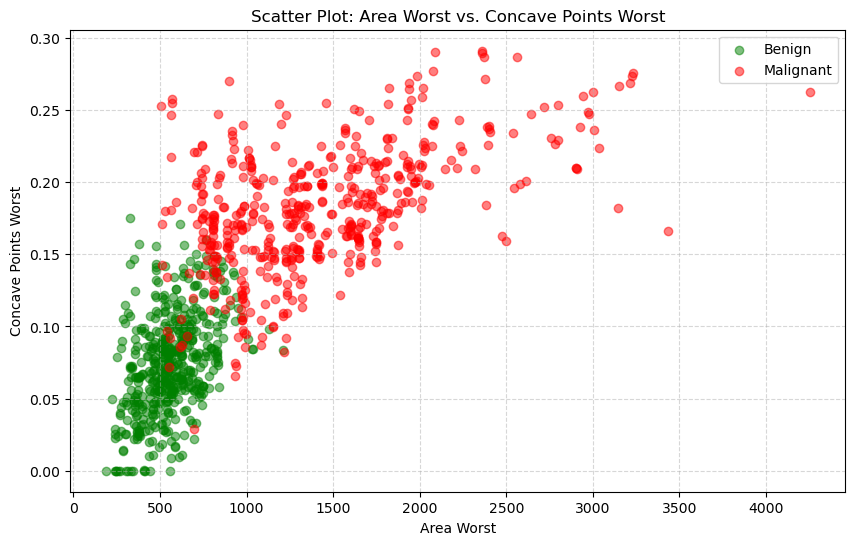

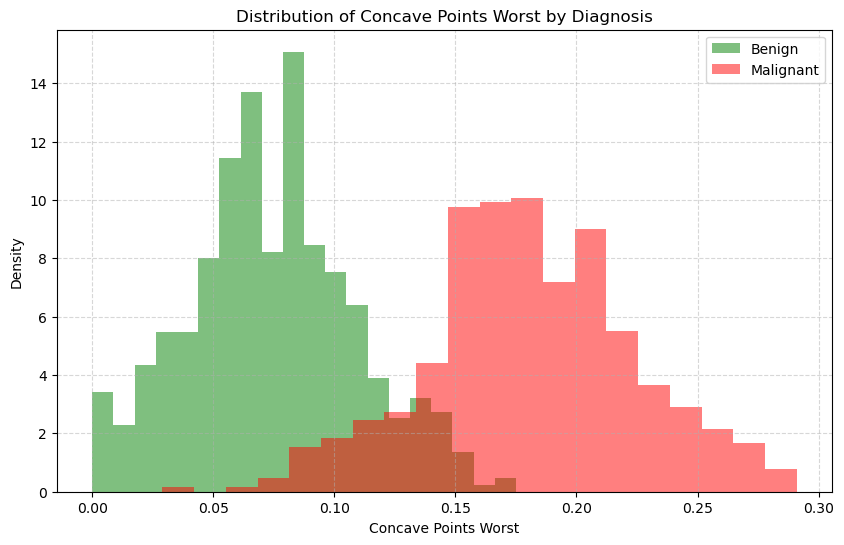

In [9]:
AREA_WORST_IDX = 23
CONCAVE_PTS_IDX = 27

m_area_worst = [row[AREA_WORST_IDX] for row, label in zip(all_features, y) if label == 'M']
m_concave_pts = [row[CONCAVE_PTS_IDX] for row, label in zip(all_features, y) if label == 'M']

b_area_worst = [row[AREA_WORST_IDX] for row, label in zip(all_features, y) if label == 'B']
b_concave_pts = [row[CONCAVE_PTS_IDX] for row, label in zip(all_features, y) if label == 'B']

# Graph 1: Scatter Plot of Top 2 Features
plt.figure(figsize=(10, 6))
plt.scatter(b_area_worst, b_concave_pts, color='green', label='Benign', alpha=0.5)
plt.scatter(m_area_worst, m_concave_pts, color='red', label='Malignant', alpha=0.5)

plt.title("Scatter Plot: Area Worst vs. Concave Points Worst")
plt.xlabel("Area Worst")
plt.ylabel("Concave Points Worst")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Histogram of Concave Points Worst
plt.figure(figsize=(10, 6))
plt.hist(b_concave_pts, bins=20, color='green', alpha=0.5, label='Benign', density=True)
plt.hist(m_concave_pts, bins=20, color='red', alpha=0.5, label='Malignant', density=True)

plt.title("Distribution of Concave Points Worst by Diagnosis")
plt.xlabel("Concave Points Worst")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Visualization Analysis   
Since the data is taken from FNA of breast masses, we use the "worst" metric since it is the largest instance found in an image."Worst"  
helps us analyze the dataset best because the largest instance of a malignant sample will be much larger than the largest instance of a benign.   
As we can see from the two graphs, there is a direct correlation between area and concave points, and samples with more area and concave   
points  are malignant.

### Classification Results

In [10]:
dt_confusion_matrix = myevaluation.confusion_matrix(dt_all_y_true, dt_all_y_pred, labels)
dummy_confusion_matrix = myevaluation.confusion_matrix(dummy_all_y_true, dummy_all_y_pred, labels)

# Comparison Summary
print("\n\n" + "="*60)
print("CLASSIFIER COMPARISON SUMMARY")
print("="*60)
print(f"{'Metric':<25} {'Naive Bayes':>12} {'Random Forest':>14} {'Decision Tree':>14} {'Dummy':>12}")
print("-"*90)
print(f"{'Accuracy':<25} {nb_accuracy:>12.4f} {rf_accuracy:>14.4f} {dt_accuracy:>14.4f} {dummy_accuracy:>12.4f}")
print(f"{'Error Rate':<25} {nb_error_rate:>12.4f} {rf_error_rate:>14.4f} {dt_error_rate:>14.4f} {dummy_error_rate:>12.4f}")
print(f"{'Precision (Malignant)':<25} {nb_precision:>12.4f} {rf_precision:>14.4f} {dt_precision:>14.4f} {dummy_precision:>12.4f}")
print(f"{'Recall (Malignant)':<25} {nb_recall:>12.4f} {rf_recall:>14.4f} {dt_recall:>14.4f} {dummy_recall:>12.4f}")
print(f"{'F1 Score (Malignant)':<25} {nb_f1:>12.4f} {rf_f1:>14.4f} {dt_f1:>14.4f} {dummy_f1:>12.4f}")
print("="*90)



CLASSIFIER COMPARISON SUMMARY
Metric                     Naive Bayes  Random Forest  Decision Tree        Dummy
------------------------------------------------------------------------------------------
Accuracy                        0.9360         0.9550         0.9550       0.4640
Error Rate                      0.0640         0.0450         0.0450       0.5360
Precision (Malignant)           0.9504         0.9615         0.9559       0.4550
Recall (Malignant)              0.9200         0.9480         0.9540       0.3640
F1 Score (Malignant)            0.9350         0.9547         0.9550       0.4044


## Performance Analysis

For this breast cancer classification task, we implemented and evaluated four distinct classifiers to predict whether tumors are malignant or benign based on 30 discretized features derived from cell nuclei characteristics: Naive Bayes, Random Forest, Decision Tree, and a dummy classifier.

### Analysis of Results

**Dummy Classifier Performance**: The baseline achieved only 46.4% accuracy, confirming that random guessing performs barely better than chance.

**Naive Bayes Performance**: The Naive Bayes classifier performed well with 93.6% accuracy and strong precision (95.04%), despite the independence assumption. However, its recall (92.0%) was the lowest among the three main classifiers, meaning it missed more malignant cases than the tree-based methods.

**Decision Tree**: The single-tree Decision Tree approach achieved an identical overall accuracy of 95.5%, demonstrating a significant performance leap compared to Naive Bayes. The Decision Tree demonstrated its highest performance in Recall (95.50%), meaning it was slightly better at correctly identifying and catching all the positive (malignant) cases. The model's precision was strong at 95.47%, resulting in an F1 Score of 95.50%, indicating a high level of balanced predictive performance.   

**Random Forest**: The Random Forest ensemble model achieved an overall accuracy of 95.5%, representing a significant improvement over the baseline Naive Bayes approach. The model's primary strength was its Precision (96.15%), the highest recorded among all models. This strong precision indicates that the Random Forest makes very few false positive predictions. The model maintained a high Recall of 95.40% and an F1 Score of 95.47%, confirming its excellent balance and reliability.

### Best Classifier

**Winner: Random Forest Classifier**   
Random forest tied for the highest overall accuracy of 95.5%, but beat out the rest of the classifiers by having the highest precision (96.15%) and F1 score (95.47%)
The classifier's combination of high accuracy, precision, ensemble stability, and balanced performance makes it the most reliable choice for breast cancer tumor classification in this project.

## Conclusion

This project successfully developed and evaluated machine learning classifiers for breast cancer diagnosis using the Wisconsin Breast Cancer dataset. The dataset contained 30 numerical features derived from digitized images of fine needle aspirate (FNA) of breast masses, describing characteristics of cell nuclei such as radius, texture, perimeter, area, smoothness, compactness, concavity, and symmetry. 

### Dataset Challenges

1. **Class Imbalance**: The dataset exhibited an imbalance between malignant and benign samples, which we addressed using the SMOTE (Synthetic Minority Over-sampling Technique) algorithm to augment the dataset from approximately 600 to 1,000 instances with balanced class distribution
2. **High Dimensionality**: With 30 features per instance, the risk of overfitting and curse of dimensionality required careful feature engineering and algorithm selection
3. **Continuous Feature Values**: The raw numerical features required discretization to work effectively with our chosen classification algorithms, which we achieved through quartile-based binning into four categories per feature

### Classification Approach

Our classification approach involved implementingclassifiers—Naive Bayes, Random Forest, Decision Tree, and Dummy Classifier—each evaluated using  10-fold cross-validation. We discretized all 30 features into categorical bins based on quartiles. The Random Forest classifier was configured with 20 trees using bootstrap sampling and random feature selection to create a robust ensemble model.

### Classifier Performance

The results demonstrated strong predictive performance across all feature-based classifiers, but the Random Forest classifier emerged as the "best" classifier due to its highest precision and onsistent cross-fold performance.

### Future Improvements

1. **Feature Selection and Engineering**: Implement feature importance analysis to identify the most predictive features and potentially reduce dimensionality while maintaining or improving accuracy. 
5. **Deep Learning Approaches**: Investigate neural network architectures that can learn directly from continuous features without discretization, potentially capturing more patterns in the data.

### Acknowledgements
SMOTE Algorithm: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/    
Dataset: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data   
Libraries: https://matplotlib.org/